In [19]:
# # # # # # # # # # #函数列表# # # # # # # # # # #

##填充函数-使用零填充数据集X的所有图像。填充应用于图像的高度和宽度（使卷积后的矩阵保持原有维度）
#zero_pad(X, pad):

## 单步卷积
#conv_single_step(a_slice_prev, W, b):

## 卷积层向前传播
#def conv_forward(A_prev, W, b, hparameters):

## 池化层向前传播
#def pool_forward(A_prev, hparameters, mode = "max"):

##卷积层向后传播
#def conv_backward(dZ, cache):
    
##计算池化层反向传播的准备函数
#def create_mask_from_window(x):
# def distribute_value(dz, shape):

##池化层向后传播
# def pool_backward(dA, cache, mode = "max"):



In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


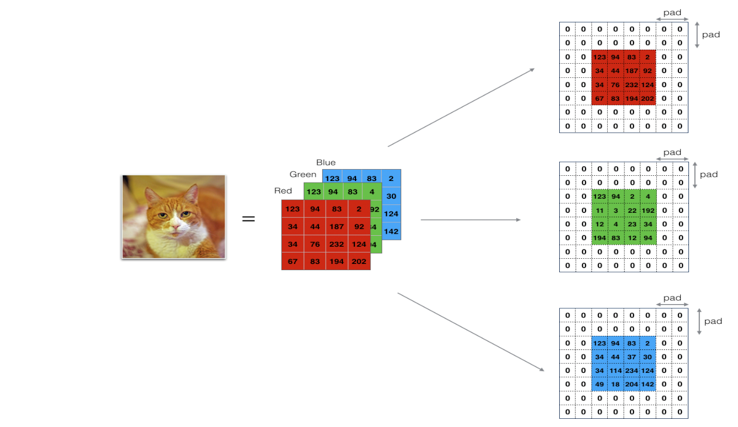

In [21]:
# 填充函数

def zero_pad(X, pad):
    """
    使用零填充数据集X的所有图像。填充应用于图像的高度和宽度，
    如上图所示。

    Argument:
    X -- shape (m, n_H, n_W, n_C)
    pad -- integer, 垂直和水平尺寸上每个图像周围的填充量
    
    Returns:
    X_pad -- shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    
    """
    #m为训练样本数量，n_C为通道数，不需要填充
    X_pad = np.pad(X, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant')
    
    return X_pad

x.shape = (4, 3, 3, 2)
x_pad.shape = (4, 7, 7, 2)
x[1,1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_pad[1,1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


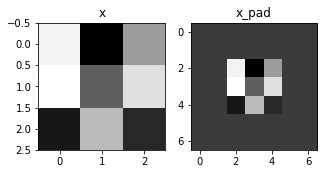

In [22]:
#test
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =", x.shape)
print ("x_pad.shape =", x_pad.shape)
print ("x[1,1] =", x[1,1])
print ("x_pad[1,1] =", x_pad[1,1])

fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

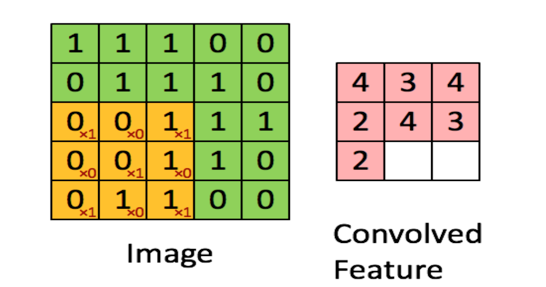

In [23]:
# 单步卷积

def conv_single_step(a_slice_prev, W, b):
    """
    在上一层输出的激活值的单个切片（a_slice_prev）上应用由参数W定义的一个过滤器
    
    Arguments:
    a_slice_prev --切片数据 -- shape (f, f, n_C_prev)
    W -- 过滤器 -- shape (f, f, n_C_prev)
    b -- Bias -- shape (1, 1, 1)
    
    Returns:
    Z -- 卷积的数值结果
    """

    s = np.multiply(a_slice_prev,W)
    Z = np.sum(s)
    Z = Z+float(b)
    
    return Z

In [24]:
#test
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)

Z = conv_single_step(a_slice_prev, W, b)
# print("a_slice_prev =",a_slice_prev)
# print("W =",W)
# print("b =",b)
print("Z =", Z)

Z = -6.999089450680221


In [25]:
# 卷积层向前传播

def conv_forward(A_prev, W, b, hparameters):
    """
    Arguments:
    A_prev -- 前一层的激活值 -- shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- 过滤器 -- shape (f, f, n_C_prev, n_C)
    b -- Biases -- shape (1, 1, 1, n_C)
    hparameters -- ["stride"，"pad"]
        
    Returns:
    Z -- 卷积的输出 shape (m, n_H, n_W, n_C)
    cache -- 反向传播需要的参数
    """
    
    # 前一层激活值的shape
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    # 过滤器的shape
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    # 计算卷积结果的维度
    n_H = int(np.floor((n_H_prev+2*pad-f)/stride)+1)
    n_W = int(np.floor((n_W_prev+2*pad-f)/stride)+1)
    
    Z = np.zeros((m,n_H,n_W,n_C))
    
    #  填充0以保持输出的维度
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):                               # 训练样例循环
        a_prev_pad = A_prev_pad[i]                   # 第i个训练样本
        for h in range(n_H):                           # 循环输出结果的H维度
            for w in range(n_W):                       # 循环输出结果的W维度
                for c in range(n_C):                   # 循环输出结果的通道维度
                    
                    # 计算切片在样本中的位置
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # 利用位置信息得到切片
                    a_slice_prev = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:]
                    
                    # 该切片与第c个过滤器和第c个bias做运算得出第i个测试用例的第c个通道的（h，w）位置的值
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[:,:,:,c], b[:,:,:,c])
                                        
   
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    #保存信息以便反向传播使用
    cache = (A_prev, W, b, hparameters)
    
    return Z, cache

In [26]:
#test
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2,
               "stride": 2}

Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =", np.mean(Z))
print("Z[3,2,1] =", Z[3,2,1])
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

Z's mean = 0.048995203528855794
Z[3,2,1] = [-0.61490741 -6.7439236  -2.55153897  1.75698377  3.56208902  0.53036437
  5.18531798  8.75898442]
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [27]:
# 池化层向前传播

def pool_forward(A_prev, hparameters, mode = "max"):
    """
    Arguments:
    A_prev -- 前一层的激活值 -- shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- ["f","stride"]
    mode -- 池化函数类型 -- ("max" or "average")
    
    Returns:
    A -- 池化层的输出--shape (m, n_H, n_W, n_C)
    cache -- 反向传播需要的参数
    """
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    f = hparameters["f"]
    stride = hparameters["stride"]
    
    # 输出的维度计算
    n_H = int(np.floor((n_H_prev-f)/stride)+1)
    n_W = int(np.floor((n_W_prev-f)/stride)+1)
    n_C = n_C_prev
    
    # 初始化输出矩阵
    A = np.zeros((m, n_H, n_W, n_C))              
    
    
    for i in range(m):                         
        for h in range(n_H):                    
            for w in range(n_W):                 
                for c in range (n_C):            
                    
                    # 计算切片在样本中的位置
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    # 利用位置信息得到切片
                    a_prev_slice = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]
                    
                    # 根据池化函数类型，作用在切片上得到第i个测试用例的输出的第c个通道的（h，w）位置的值
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.average(a_prev_slice)
    
    
    cache = (A_prev, hparameters)
    
    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

In [28]:
#test
np.random.seed(1)
A_prev = np.random.randn(2, 4, 4, 3)
hparameters = {"stride" : 2, "f": 3}

A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 0.86540763 1.13376944]]]


 [[[1.13162939 1.51981682 2.18557541]]]]

mode = average
A = [[[[ 0.02105773 -0.20328806 -0.40389855]]]


 [[[-0.22154621  0.51716526  0.48155844]]]]


In [29]:
#卷积层向后传播
def conv_backward(dZ, cache):
    """
    
    Arguments:
    dZ -- 卷积层输出的梯度 shape (m, n_H, n_W, n_C)
    cache -- 前向传播函数输出的cache
    
    Returns:
    dA_prev -- 卷积层的输入梯度
               numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    dW -- 卷积层众过滤器的梯度 -- shape (f, f, n_C_prev, n_C)
    db -- 各层bias的梯度 -- shape (1, 1, 1, n_C)
    """
    
    
    (A_prev, W, b, hparameters) = cache
    
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    
    (f, f, n_C_prev, n_C) = W.shape
    
    stride = hparameters['stride']
    pad = hparameters['pad']
    
    (m, n_H, n_W, n_C) = dZ.shape
    
    # 初始化梯度矩阵维度
    dA_prev = np.zeros(A_prev.shape)                           
    dW = np.zeros(W.shape)
    db = np.zeros(b.shape)

    # 用0填充
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):                       
        
        a_prev_pad = A_prev_pad[i] #第i个样本的输入
        da_prev_pad = dA_prev_pad[i] #第i个样本的输入梯度
        
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range(n_C):           
                    
                     # 计算切片在样本中的位置
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    #利用位置信息得到切片
                    a_slice = a_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :]

                    # 利用梯度公式计算梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c]*dZ[i,h,w,c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        #计算dA_prev
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad,pad:-pad,:]
    
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

In [30]:
np.random.seed(1)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


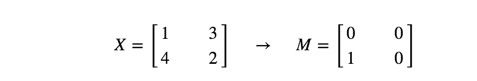

In [31]:
#计算池化层反向传播的准备函数——max pooling
def create_mask_from_window(x):
    """
    Arguments:
    x -- shape (f, f)
    
    Returns:
    mask -- 与窗口形状相同的数组，在与x的最大条目对应的位置包含True。

    """
    
    mask = (x==np.max(x))
    
    return mask

In [32]:
#test
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


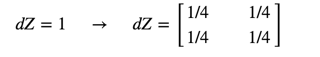

In [33]:
#计算池化层反向传播的准备函数——average pooling
def distribute_value(dz, shape):
    """
    
    Arguments:
    dz -- 输入的dZ
    shape -- 我们想要分配dz值的输出矩阵 -- shape (n_H, n_W)
    
    Returns:
    a -- 分发了dz的值 --  size (n_H, n_W)
    """
    
    (n_H, n_W) =shape
    
    average = dz/(n_H*n_W)
    
    a = np.ones((n_H,n_W))*average
    
    return a

In [34]:
#test
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


In [35]:
#池化层反向传播
def pool_backward(dA, cache, mode = "max"):
    """
    
    Arguments:
    dA -- 相对于池化层输出的成本梯度，与A的形状相同
    cache -- 前向传播的cache
    mode -- 使用哪种池化反向传播("max" or "average")
    
    Returns:
    dA_prev -- 相对于池化层输入的成本梯度，与A_prev相同的形状
    
    """

    (A_prev, hparameters) = cache
    

    stride = hparameters['stride']
    f = hparameters['f']
    
    
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    #初始化输出矩阵
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(m):                       
        
        #第i个训练样本
        a_prev = A_prev[i]
        
        for h in range(n_H):                   
            for w in range(n_W):               
                for c in range(n_C):           
                    
                    # 计算切片在样本中的位置
                    vert_start = h*stride
                    vert_end = vert_start+f
                    horiz_start = w*stride
                    horiz_end = horiz_start+f
                    
                    #利用位置信息得到切片
                    if mode == "max":
                        
                        # 利用位置信息得到切片
                        a_prev_slice = a_prev[vert_start:vert_end, horiz_start:horiz_end, c]
                        # 切片的mask
                        mask = create_mask_from_window(a_prev_slice)
                        # 计算dA_prev
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += np.multiply(mask,dA[i,h,w,c])
                        
                    elif mode == "average":
                        
                        # 拿到该点的da
                        da = dA[i,h,w,c]
                        # 定义切片的大小
                        shape = (f,f)
                        # 计算对应范围的dA_prev
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da,shape)
                        
   
    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

In [36]:
#test
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
